In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import utils
import lsm
from skimage import img_as_float
from scipy.ndimage import gaussian_filter, convolve

In [2]:
class myLSM(lsm.LSM):
    # initialize phi with a quadratic function
    def initialize_phi(self, x_s=0.5, y_s=0.5, radius=0.05):
        x = np.linspace(0.5/self.n1,1-0.5/self.n1,self.n1)
        y = np.linspace(0.5/self.n2,1-0.5/self.n2,self.n2)
        x, y = np.meshgrid(x,y)
        
        self.phi = - (x-x_s)**2 - (y-y_s)**2 + radius**2

### Data Preprocessing
Load data and then apply preprocessing.
Use a pipeline of:
1. Gaussian blur
2. Box filter (double smoothing sometimes hurts performance depending on how much noise is in image)
3. Principal curvature
4. Contrast enhancement

Principal curvature method found in: https://github.com/srngshkr/Retinal-Image-Processing

Method is good at getting rid of false positives (artifacts) but prunes lightly shaded veins as a tradeoff.
May not be good as a standalone method.

In [3]:
# Get Data
data = utils.obtain_data("../../data/vessels")  # add your path here
train_data = data['train']
train_names = train_data['names']
train_images = train_data['images']
train_labels = train_data['labels']

# Image size
n1 = 512
n2 = 512

def preprocess_img(img_index, sigma=2.0, clip_limit=1.0):
    image = train_images[img_index]
    image = cv2.resize(image, (n2, n1))  # Resizing to (n2,n1)
    label = train_labels[img_index]
    label = cv2.resize(label, (n2, n1))  # Resizing to (n2,n1)

    # Apply Gaussian blur
    k = np.ones((7, 7))
    gimage = gaussian_filter(image, sigma=sigma)
    gimage = convolve(gimage, k)

    # Obtain principal curvatures
    mpc = utils.principal_curvature(gimage)*-1
    mpc = utils.scale_to_uint(mpc)

    # Improve contrast
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(2, 2))
    pr_image = img_as_float(np.array(clahe.apply(np.expand_dims(mpc, axis=-1))).squeeze())

    # Find optimal starting point dependent on darkest region (could be improved)
    x_s, y_s = utils.find_start_point(image)

    return image, pr_image, label, x_s, y_s

### Results
Run level set method on preprocessed images in training set.

Image: 52al.png


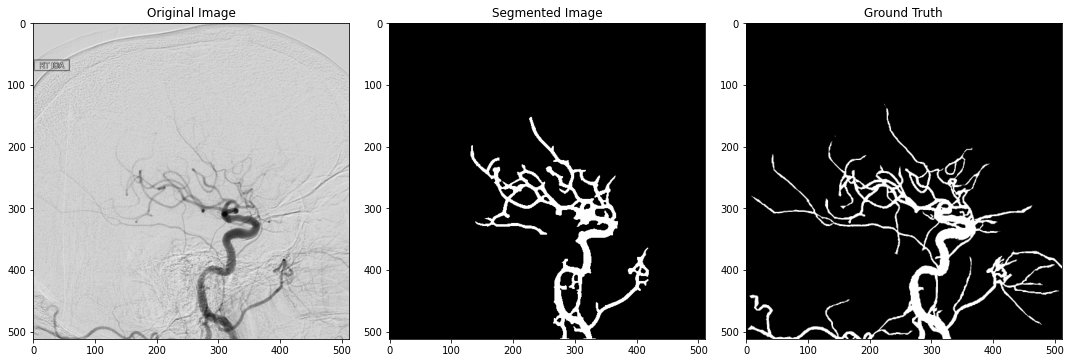

Image: 53al.png


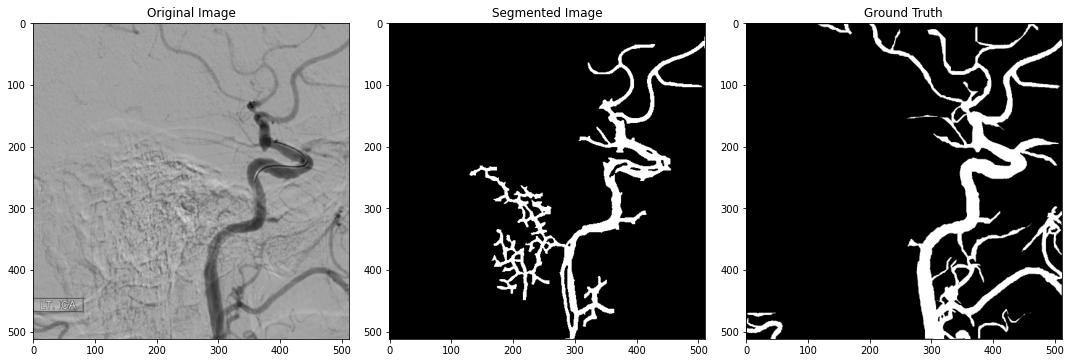

Image: 53bf.png


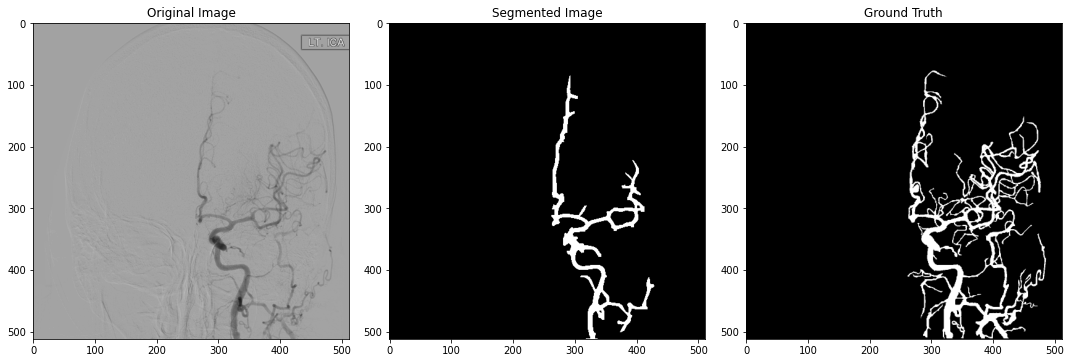

Image: 54bl.png


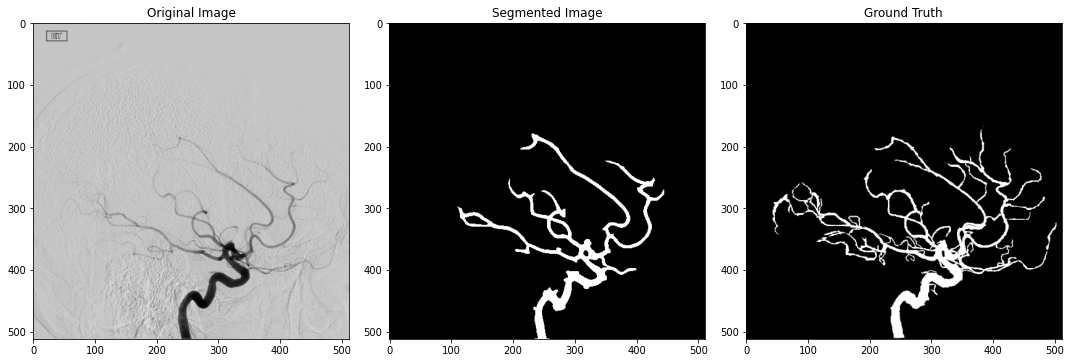

Image: 54bf.png


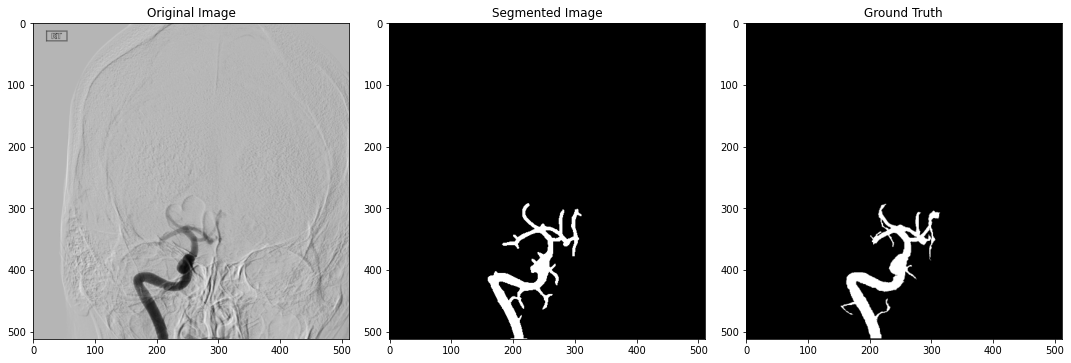

Image: 59bl.png


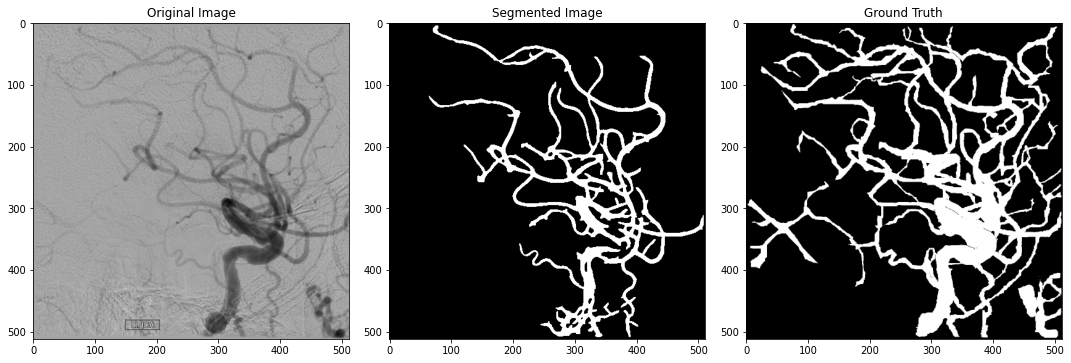

Image: 59bf.png


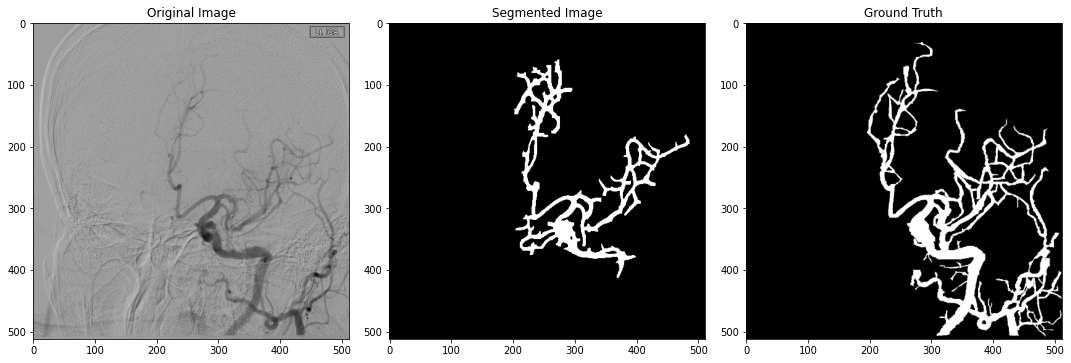

Image: 61bl.png


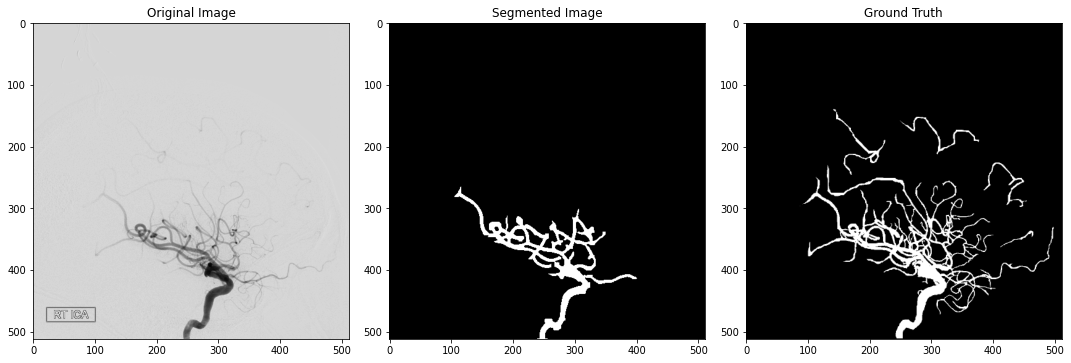

Image: 62bf.png


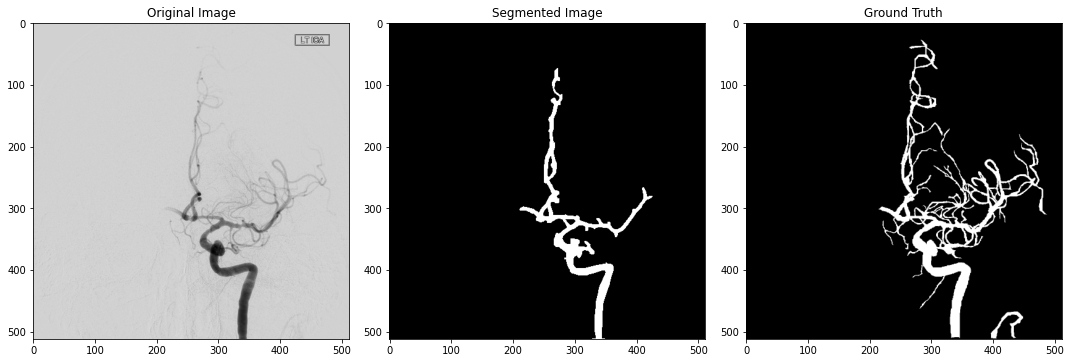

Image: 64bl.png


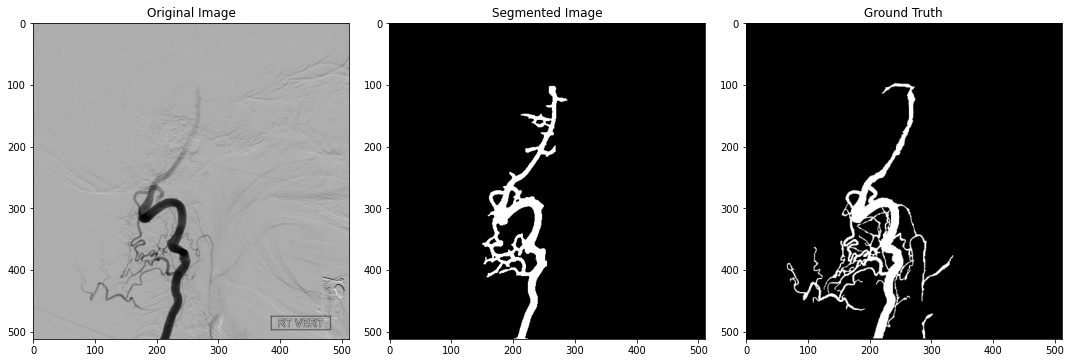

Image: 68bf.png


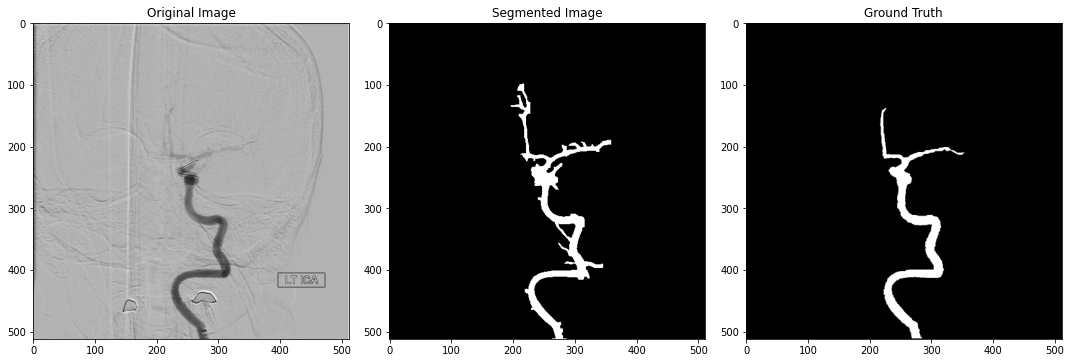

Image: 69bl.png


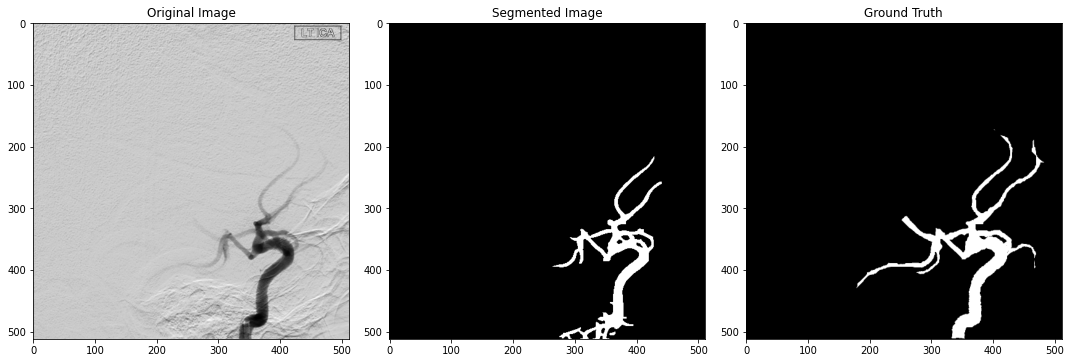

Image: 71al.png


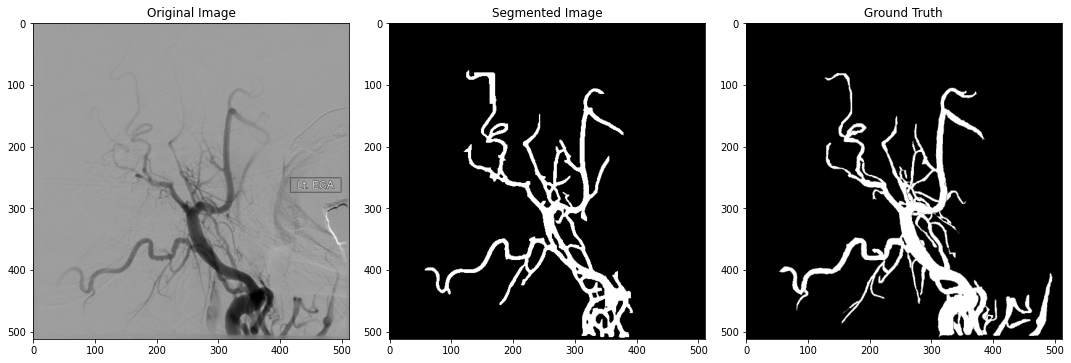

Image: 73af.png


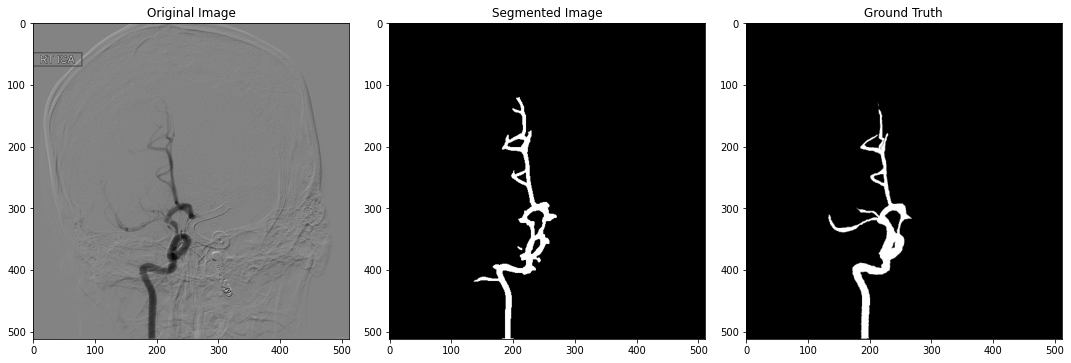

Image: 73al.png


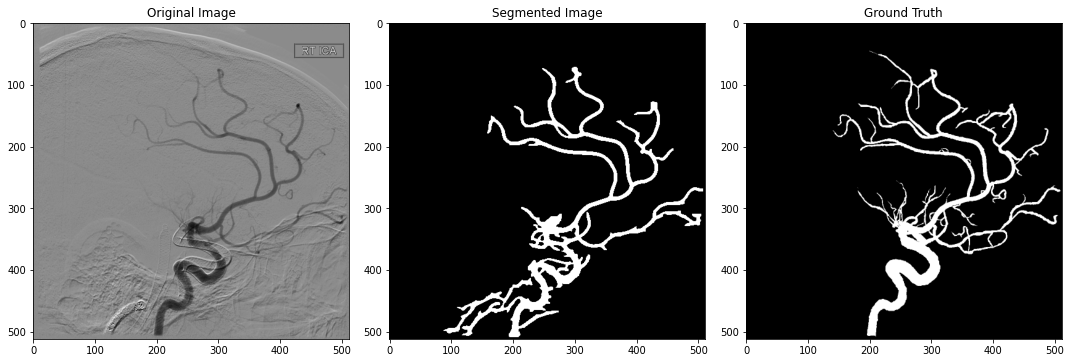

In [4]:
# Define parameters
rho = 1
sigma = 1e-6  # sigma of level set, not preprocess blur
omega = 0.5
epsilon = 0.5

max_iter = 400  # Maximum iterations
print_every = 50  # Verbose. Print every [print_every] iteration.
step_size = 250  # step size of the method

#for i in range(len(train_images)):
for i in range(15):
    image, pr_image, label, x_s, y_s = preprocess_img(i, sigma=2.0)

    # Define LSM object
    my_lsm = myLSM(n1, n2, rho, sigma, omega, epsilon)

    # Initialize phi to a circle at a certain starting point
    my_lsm.initialize_phi(x_s=x_s, y_s=y_s, radius=0.0375)

    # Run a method.
    phi = utils.run_lsm(pr_image, my_lsm, step_size=step_size, max_iter=max_iter, print_every=print_every, do_plot=False)

    # Obtain segmentation
    segment = np.zeros_like(image)
    segment[phi >= 0] = 1
    
    # Plot final result
    print("Image: {}".format(train_names[i]))
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
       
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title("Original Image")
    
    ax[1].imshow(segment, cmap='gray')
    ax[1].set_title("Segmented Image")

    ax[2].imshow(label, 'gray')
    ax[2].set_title("Ground Truth")
    plt.tight_layout()
    plt.show()